### Q1 

Apply iLQR to the differential drive vehicle. 

In [27]:
##import all the necessary packages
import math 
import numpy as np
import matplotlib.pyplot as plt 

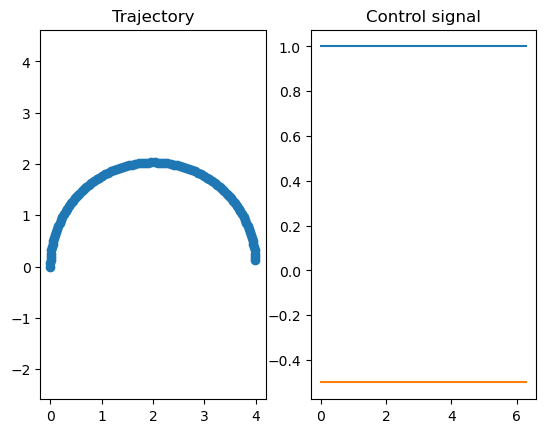

In [60]:
##Initialize our variables and create a reference trajectory--------------------------------------------
t = 2 * math.pi
timestep =  100
dt = t/timestep
time = np.linspace(0,t,timestep)

#Initialize our time step array with 5 state variables at each time step [x_1, x_2, theta, u_1, u_2 ...]
traj_ref = np.zeros(5*time.size)
traj_ref[0:5] = np.array([0,0,math.pi/2,1,-0.5])

#Create our reference trajectory
for i in range(0,495,5):
    #Calculate the intial velocities.
    traj_ref[i + 5] = traj_ref[i] + dt * traj_ref[i + 3] * math.cos(traj_ref[i + 2])
    traj_ref[i + 6] = traj_ref[i + 1] + dt * traj_ref[i + 3] * math.sin(traj_ref[i + 2])
    traj_ref[i + 7] = traj_ref[i + 2] + dt * traj_ref[i + 4]
    traj_ref[i + 8] = traj_ref[i + 3]        
    traj_ref[i + 9] = traj_ref[i + 4]    
    
#Reshape our trajectory to be in the shape we want it to be 
traj_ref = np.reshape(traj_ref,(time.size,5))

#Set the controls to zero at the very end. 

##Plots-------------------------------------------------------------------------------------------------
fig, axs = plt.subplots(1,2)
#Plotting the reference trajectory
axs[0].scatter(traj_ref[:,0], traj_ref[:,1])
axs[0].axis("equal")
axs[0].set_title("Trajectory")

#Plotting the control signal 
axs[1].plot(time, traj_ref[:,3])
axs[1].set_title("Control signal")
axs[1].plot(time, traj_ref[:,4], "tab:orange")

In [58]:
traj_ref

array([[ 0.00000000e+00,  0.00000000e+00,  3.14159265e+00,
         1.00000000e+00, -5.00000000e-01],
       [-6.28318531e-02,  7.69468277e-18,  3.11017673e+00,
         1.00000000e+00, -5.00000000e-01],
       [-1.25632702e-01,  1.97359620e-03,  3.07876080e+00,
         1.00000000e+00, -5.00000000e-01],
       [-1.88340571e-01,  5.91884090e-03,  3.04734487e+00,
         1.00000000e+00, -5.00000000e-01],
       [-2.50893574e-01,  1.18318406e-02,  3.01592895e+00,
         1.00000000e+00, -5.00000000e-01],
       [-3.13229979e-01,  1.97067599e-02,  2.98451302e+00,
         1.00000000e+00, -5.00000000e-01],
       [-3.75288268e-01,  2.95358273e-02,  2.95309709e+00,
         1.00000000e+00, -5.00000000e-01],
       [-4.37007196e-01,  4.13093425e-02,  2.92168117e+00,
         1.00000000e+00, -5.00000000e-01],
       [-4.98325855e-01,  5.50156866e-02,  2.89026524e+00,
         1.00000000e+00, -5.00000000e-01],
       [-5.59183730e-01,  7.06413330e-02,  2.85884931e+00,
         1.00000000e+00

In [59]:
dt

0.06283185307179587